<a href="https://colab.research.google.com/github/yanruyang/2022_wentz_energies/blob/main/LLM_XGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

使用设备: cpu

多模态市值预测系统
融合数值数据、新闻文本和市场情绪

示例 1: 特斯拉(TSLA) - 多模态预测
----------------------------------------------------------------------

多模态市值预测系统 - TSLA


开始收集 TSLA 的多模态数据

步骤 1/3: 获取股票数据...

步骤 2/3: 获取新闻数据...
正在获取 Tesla 的新闻数据...
提示: 未提供News API密钥，使用模拟新闻数据
获取到 3709 条新闻

步骤 3/3: 分析市场情绪...
生成 1873 天的情绪数据

数据收集完成!
最终数据集: 1740 条记录
特征数量: 26 列
日期范围: 2018-01-31 00:00:00-05:00 到 2024-12-30 00:00:00-05:00

情绪统计:
  平均情绪: 0.024
  情绪标准差: 0.057
  平均新闻数: 1.4 条/天

多模态数据集划分:
训练集: 1218 条记录
验证集: 261 条记录
测试集: 261 条记录
数值特征: 8 维
文本特征: 9 维

多模态Transformer模型:
  数值特征维度: 8
  文本特征维度: 9
  模型参数量: 228,161

开始训练多模态模型...
Epoch [10/50], Train Loss: 0.023125, Val Loss: 0.015707
Epoch [20/50], Train Loss: 0.020248, Val Loss: 0.006684
Epoch [30/50], Train Loss: 0.017726, Val Loss: 0.006462
Epoch [40/50], Train Loss: 0.015368, Val Loss: 0.006343
Epoch [50/50], Train Loss: 0.016773, Val Loss: 0.006164

训练完成!


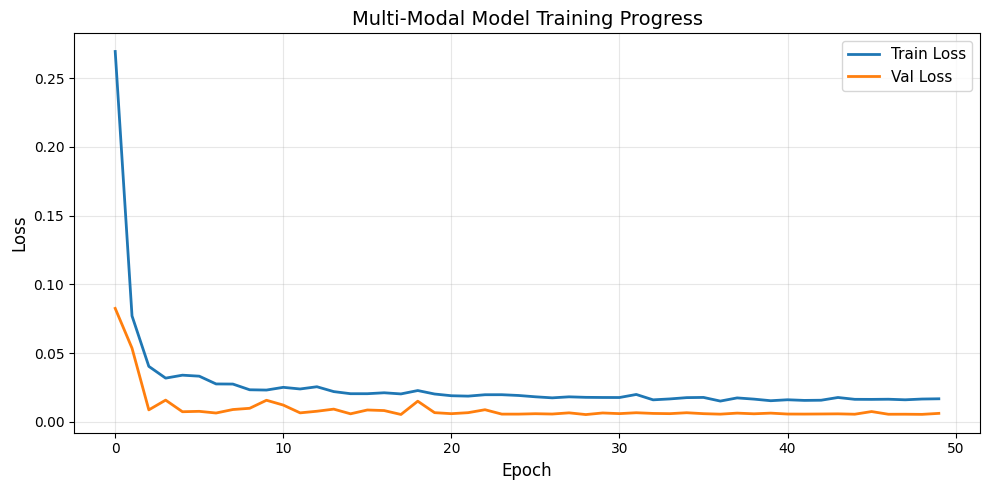


多模态模型评估结果
RMSE (均方根误差): $66,600,981,515.21
MAE (平均绝对误差): $40,792,064,790.23
R² Score (决定系数): 0.9305
MAPE (平均绝对百分比误差): 4.65%


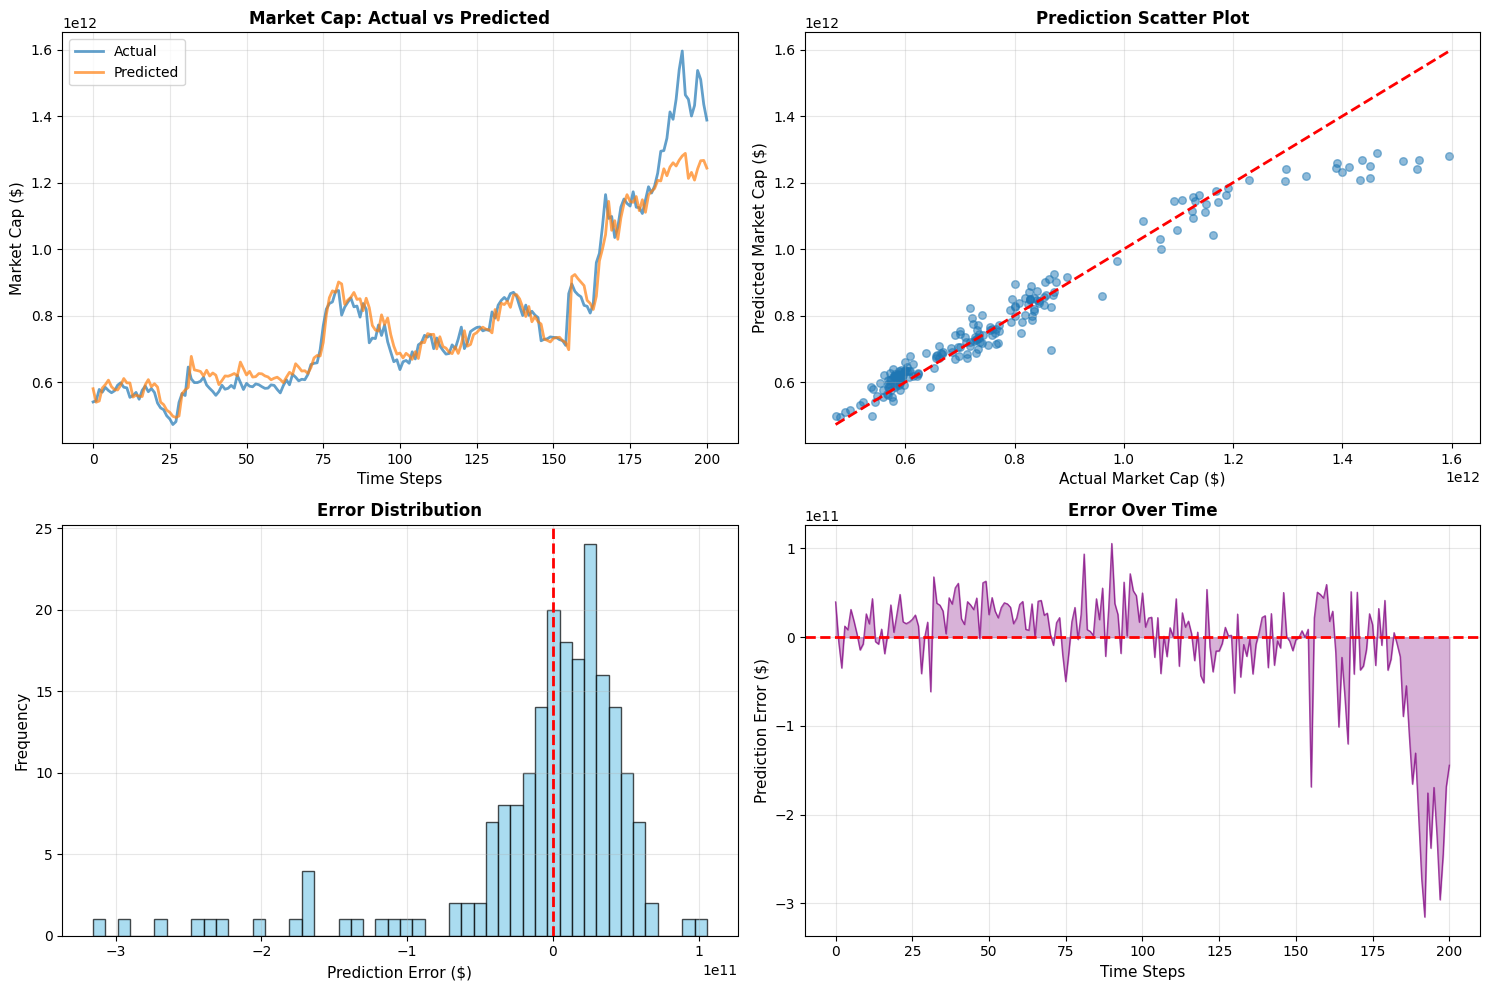


情绪影响分析
情绪得分与收益率的相关系数: -0.0244

各情绪类别的平均收益率:
                        mean       std  count
sentiment_category                           
Negative                 NaN       NaN      0
Neutral             0.002676  0.040039   1588
Positive            0.000360  0.043097    152


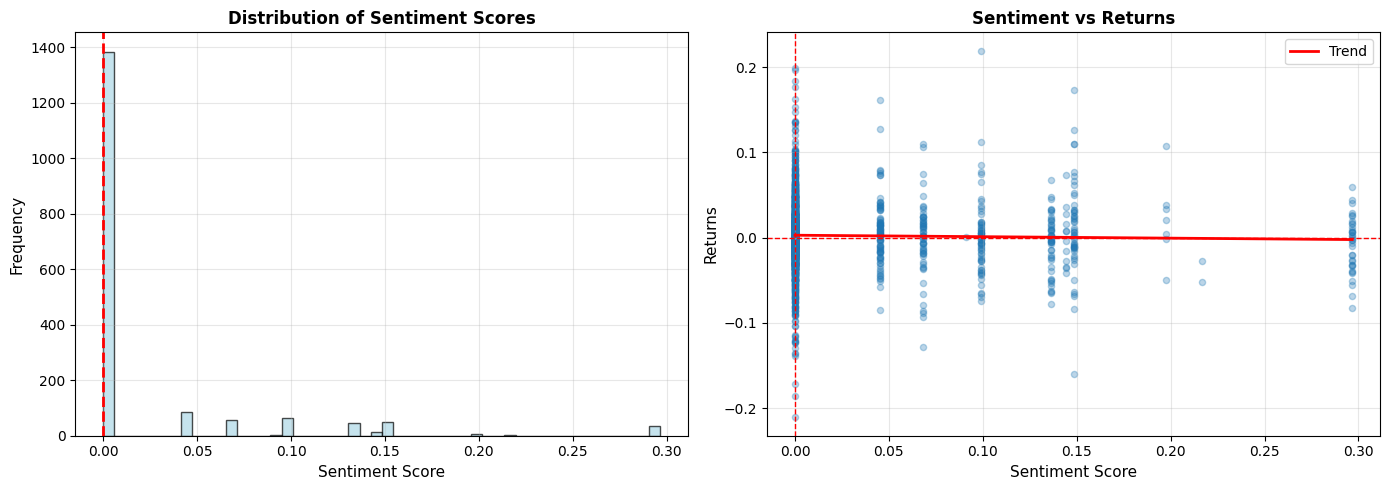



示例 2: 批量处理多家科技公司
----------------------------------------------------------------------
提示: 取消注释以下代码运行批量处理


    companies = [
        {'ticker': 'TSLA', 'name': 'Tesla'},
        {'ticker': 'AAPL', 'name': 'Apple'},
        {'ticker': 'MSFT', 'name': 'Microsoft'},
        {'ticker': 'GOOGL', 'name': 'Google'},
        {'ticker': 'NVDA', 'name': 'NVIDIA'}
    ]
    
    batch_pipeline = BatchPipeline(
        companies=companies,
        seq_length=60,
        device=device,
        news_api_key=NEWS_API_KEY
    )
    
    batch_pipeline.run_all(epochs=30, batch_size=32, lr=0.001)
    

系统特性说明

    ✅ 数据源:
       - 股票历史数据 (yfinance)
       - 公司相关新闻 (News API 或模拟数据)
       - 市场情绪分析 (TextBlob)
    
    ✅ 文本特征:
       - 情绪得分 (sentiment_score: -1到1)
       - 情绪波动 (sentiment_std)
       - 主观性分数 (sentiment_subjectivity)
       - 新闻数量 (news_count)
       - 正面/负面新闻计数
       - 情绪移动平均和趋势
    
    ✅ 模型架构:
       - 双编码器: 数值特征 + 文本特征
       - 跨模态注意力机制
       - 多头自注意力
       - 位置编码
    
    ✅ 评估指标:

In [7]:
"""
基于多模态Transformer的科技公司市值预测系统
融合数值数据、新闻文本和市场情绪
"""

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from datetime import datetime, timedelta
import requests
from textblob import TextBlob
import re
import warnings
warnings.filterwarnings('ignore')

# 设置随机种子
np.random.seed(42)
torch.manual_seed(42)


# ==================== 1. 增强版数据收集模块 ====================
class NewsCollector:
    """新闻数据收集器"""

    def __init__(self, api_key=None):
        """
        初始化新闻收集器
        api_key: News API的密钥 (可在 https://newsapi.org 免费注册)
        如果没有API key，将使用模拟数据
        """
        self.api_key = api_key
        self.base_url = "https://newsapi.org/v2/everything"

    def fetch_news(self, company_name, ticker, start_date, end_date):
        """获取公司相关新闻"""
        print(f"正在获取 {company_name} 的新闻数据...")

        if self.api_key:
            return self._fetch_real_news(company_name, ticker, start_date, end_date)
        else:
            print("提示: 未提供News API密钥，使用模拟新闻数据")
            return self._generate_mock_news(start_date, end_date)

    def _fetch_real_news(self, company_name, ticker, start_date, end_date):
        """从News API获取真实新闻"""
        news_data = []

        # 分批获取（API有时间范围限制）
        current_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)

        while current_date < end_date:
            batch_end = min(current_date + timedelta(days=30), end_date)

            params = {
                'q': f'{company_name} OR {ticker}',
                'from': current_date.strftime('%Y-%m-%d'),
                'to': batch_end.strftime('%Y-%m-%d'),
                'language': 'en',
                'sortBy': 'publishedAt',
                'apiKey': self.api_key
            }

            try:
                response = requests.get(self.base_url, params=params, timeout=10)
                if response.status_code == 200:
                    articles = response.json().get('articles', [])
                    for article in articles:
                        news_data.append({
                            'date': pd.to_datetime(article['publishedAt']).date(),
                            'title': article.get('title', ''),
                            'description': article.get('description', ''),
                            'content': article.get('content', '')
                        })
            except Exception as e:
                print(f"获取新闻时出错: {e}")

            current_date = batch_end + timedelta(days=1)

        return pd.DataFrame(news_data)

    def _generate_mock_news(self, start_date, end_date):
        """生成模拟新闻数据（用于演示）"""
        dates = pd.date_range(start=start_date, end=end_date, freq='D')

        positive_news = [
            "Company reports record quarterly earnings",
            "Stock reaches all-time high on strong demand",
            "New product launch exceeds expectations",
            "Company expands into emerging markets",
            "Innovation breakthrough announced"
        ]

        negative_news = [
            "Regulatory concerns weigh on stock",
            "Supply chain disruptions impact production",
            "Competition intensifies in key markets",
            "Profit margins under pressure",
            "Market volatility affects investor sentiment"
        ]

        neutral_news = [
            "Company holds annual shareholder meeting",
            "Quarterly results meet analyst expectations",
            "Management discusses future strategy",
            "Industry trends analysis released",
            "Market conditions remain stable"
        ]

        news_data = []
        for date in dates:
            # 随机选择新闻数量（0-3条/天）
            n_news = np.random.randint(0, 4)
            for _ in range(n_news):
                sentiment_type = np.random.choice(['positive', 'negative', 'neutral'],
                                                  p=[0.4, 0.3, 0.3])
                if sentiment_type == 'positive':
                    title = np.random.choice(positive_news)
                elif sentiment_type == 'negative':
                    title = np.random.choice(negative_news)
                else:
                    title = np.random.choice(neutral_news)

                news_data.append({
                    'date': date.date(),
                    'title': title,
                    'description': title,
                    'content': title
                })

        return pd.DataFrame(news_data)


class SentimentAnalyzer:
    """情绪分析器"""

    @staticmethod
    def analyze_sentiment(text):
        """分析文本情绪
        返回: (极性分数: -1到1, 主观性分数: 0到1)
        """
        if not text or pd.isna(text):
            return 0.0, 0.0

        # 清理文本
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # 使用TextBlob进行情绪分析
        try:
            blob = TextBlob(text)
            return blob.sentiment.polarity, blob.sentiment.subjectivity
        except:
            return 0.0, 0.0

    @staticmethod
    def aggregate_daily_sentiment(news_df):
        """聚合每日情绪指标"""
        if news_df.empty:
            return pd.DataFrame(columns=['date', 'sentiment_score', 'sentiment_subjectivity',
                                        'news_count', 'positive_count', 'negative_count'])

        # 分析每条新闻的情绪
        sentiments = []
        for _, row in news_df.iterrows():
            text = f"{row['title']} {row['description']}"
            polarity, subjectivity = SentimentAnalyzer.analyze_sentiment(text)
            sentiments.append({
                'date': row['date'],
                'polarity': polarity,
                'subjectivity': subjectivity
            })

        sentiment_df = pd.DataFrame(sentiments)

        # 按日期聚合
        daily_sentiment = sentiment_df.groupby('date').agg({
            'polarity': ['mean', 'std', 'min', 'max'],
            'subjectivity': 'mean'
        }).reset_index()

        daily_sentiment.columns = ['date', 'sentiment_score', 'sentiment_std',
                                   'sentiment_min', 'sentiment_max', 'sentiment_subjectivity']

        # 计算新闻数量和情绪分类
        news_count = sentiment_df.groupby('date').size().reset_index(name='news_count')
        positive_count = sentiment_df[sentiment_df['polarity'] > 0.1].groupby('date').size().reset_index(name='positive_count')
        negative_count = sentiment_df[sentiment_df['polarity'] < -0.1].groupby('date').size().reset_index(name='negative_count')

        # 合并所有指标
        daily_sentiment = daily_sentiment.merge(news_count, on='date', how='left')
        daily_sentiment = daily_sentiment.merge(positive_count, on='date', how='left')
        daily_sentiment = daily_sentiment.merge(negative_count, on='date', how='left')
        daily_sentiment = daily_sentiment.fillna(0)

        return daily_sentiment


class EnhancedMarketCapDataCollector:
    """增强版市值数据收集器（融合新闻和情绪）"""

    def __init__(self, ticker, company_name=None, start_date='2018-01-01',
                 end_date='2024-12-31', news_api_key=None):
        self.ticker = ticker
        self.company_name = company_name or ticker
        self.start_date = start_date
        self.end_date = end_date
        self.news_collector = NewsCollector(news_api_key)

    def fetch_data(self):
        """获取完整的多模态数据"""
        print(f"\n{'='*60}")
        print(f"开始收集 {self.ticker} 的多模态数据")
        print(f"{'='*60}\n")

        # 1. 获取股票数据和市值
        print("步骤 1/3: 获取股票数据...")
        stock = yf.Ticker(self.ticker)
        df = stock.history(start=self.start_date, end=self.end_date)

        # 计算市值
        shares_outstanding = stock.info.get('sharesOutstanding', None)
        if shares_outstanding:
            df['Market_Cap'] = df['Close'] * shares_outstanding
        else:
            print("警告: 无法获取股票数量，使用收盘价作为市值代理")
            df['Market_Cap'] = df['Close']

        # 添加技术指标
        df['Returns'] = df['Close'].pct_change()
        df['Volume_Change'] = df['Volume'].pct_change()
        df['High_Low_Range'] = (df['High'] - df['Low']) / df['Close']
        df['MA_5'] = df['Close'].rolling(window=5).mean()
        df['MA_20'] = df['Close'].rolling(window=20).mean()
        df['Volatility'] = df['Returns'].rolling(window=20).std()

        # 2. 获取新闻数据
        print("\n步骤 2/3: 获取新闻数据...")
        news_df = self.news_collector.fetch_news(
            self.company_name, self.ticker, self.start_date, self.end_date
        )
        print(f"获取到 {len(news_df)} 条新闻")

        # 3. 分析情绪并聚合
        print("\n步骤 3/3: 分析市场情绪...")
        daily_sentiment = SentimentAnalyzer.aggregate_daily_sentiment(news_df)
        print(f"生成 {len(daily_sentiment)} 天的情绪数据")

        # 4. 合并所有数据
        df = df.reset_index()
        df['date'] = df['Date'].dt.date

        # 转换情绪数据的日期格式
        if not daily_sentiment.empty:
            daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date']).dt.date

        # 合并数据
        df = df.merge(daily_sentiment, on='date', how='left')

        # 填充缺失的情绪数据（没有新闻的日期）
        sentiment_cols = ['sentiment_score', 'sentiment_std', 'sentiment_min',
                         'sentiment_max', 'sentiment_subjectivity', 'news_count',
                         'positive_count', 'negative_count']

        for col in sentiment_cols:
            if col in df.columns:
                df[col] = df[col].fillna(0)

        # 添加滚动情绪特征（捕捉情绪趋势）
        if 'sentiment_score' in df.columns:
            df['sentiment_ma_3'] = df['sentiment_score'].rolling(window=3).mean()
            df['sentiment_ma_7'] = df['sentiment_score'].rolling(window=7).mean()
            df['sentiment_trend'] = df['sentiment_score'] - df['sentiment_ma_7']

        df = df.set_index('Date')
        df = df.dropna()

        print(f"\n数据收集完成!")
        print(f"最终数据集: {len(df)} 条记录")
        print(f"特征数量: {len(df.columns)} 列")
        print(f"日期范围: {df.index[0]} 到 {df.index[-1]}")

        # 显示情绪统计
        if 'sentiment_score' in df.columns:
            print(f"\n情绪统计:")
            print(f"  平均情绪: {df['sentiment_score'].mean():.3f}")
            print(f"  情绪标准差: {df['sentiment_score'].std():.3f}")
            print(f"  平均新闻数: {df['news_count'].mean():.1f} 条/天")

        return df


# ==================== 2. 增强版数据预处理模块 ====================
class MultiModalTimeSeriesDataset(Dataset):
    """多模态时间序列数据集"""

    def __init__(self, numeric_data, text_features, seq_length):
        self.numeric_data = numeric_data
        self.text_features = text_features
        self.seq_length = seq_length

    def __len__(self):
        return len(self.numeric_data) - self.seq_length

    def __getitem__(self, idx):
        # 数值特征序列
        numeric_seq = self.numeric_data[idx:idx+self.seq_length, :-1]
        # 文本特征序列
        text_seq = self.text_features[idx:idx+self.seq_length]
        # 目标值
        target = self.numeric_data[idx+self.seq_length, -1]

        return (torch.FloatTensor(numeric_seq),
                torch.FloatTensor(text_seq),
                torch.FloatTensor([target]))


class EnhancedDataPreprocessor:
    """增强版数据预处理器"""

    def __init__(self, seq_length=60, train_ratio=0.7, val_ratio=0.15):
        self.seq_length = seq_length
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.scaler_numeric = StandardScaler()
        self.scaler_text = StandardScaler()
        self.scaler_y = StandardScaler()

    def prepare_data(self, df):
        """准备多模态训练数据"""

        # 数值特征
        numeric_features = ['Close', 'Volume', 'Returns', 'Volume_Change',
                           'High_Low_Range', 'MA_5', 'MA_20', 'Volatility']

        # 文本/情绪特征
        text_features = ['sentiment_score', 'sentiment_std', 'sentiment_subjectivity',
                        'news_count', 'positive_count', 'negative_count',
                        'sentiment_ma_3', 'sentiment_ma_7', 'sentiment_trend']

        # 检查特征是否存在
        available_text_features = [f for f in text_features if f in df.columns]

        if not available_text_features:
            print("警告: 没有找到文本特征，将只使用数值特征")
            available_text_features = ['sentiment_score']  # 创建默认零特征
            df['sentiment_score'] = 0

        target_col = 'Market_Cap'

        # 提取数据
        X_numeric = df[numeric_features].values
        X_text = df[available_text_features].values
        y = df[target_col].values.reshape(-1, 1)

        # 标准化
        X_numeric_scaled = self.scaler_numeric.fit_transform(X_numeric)
        X_text_scaled = self.scaler_text.fit_transform(X_text)
        y_scaled = self.scaler_y.fit_transform(y)

        # 合并数值特征和目标（用于兼容）
        numeric_data = np.concatenate([X_numeric_scaled, y_scaled], axis=1)

        # 划分数据集
        n = len(numeric_data)
        train_end = int(n * self.train_ratio)
        val_end = int(n * (self.train_ratio + self.val_ratio))

        train_numeric = numeric_data[:train_end]
        train_text = X_text_scaled[:train_end]

        val_numeric = numeric_data[train_end:val_end]
        val_text = X_text_scaled[train_end:val_end]

        test_numeric = numeric_data[val_end:]
        test_text = X_text_scaled[val_end:]

        print(f"\n多模态数据集划分:")
        print(f"训练集: {len(train_numeric)} 条记录")
        print(f"验证集: {len(val_numeric)} 条记录")
        print(f"测试集: {len(test_numeric)} 条记录")
        print(f"数值特征: {len(numeric_features)} 维")
        print(f"文本特征: {len(available_text_features)} 维")

        return (train_numeric, train_text), (val_numeric, val_text), (test_numeric, test_text)

    def create_dataloaders(self, train_data, val_data, test_data, batch_size=32):
        """创建多模态数据加载器"""
        train_numeric, train_text = train_data
        val_numeric, val_text = val_data
        test_numeric, test_text = test_data

        train_dataset = MultiModalTimeSeriesDataset(train_numeric, train_text, self.seq_length)
        val_dataset = MultiModalTimeSeriesDataset(val_numeric, val_text, self.seq_length)
        test_dataset = MultiModalTimeSeriesDataset(test_numeric, test_text, self.seq_length)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)
        test_loader = DataLoader(test_dataset, batch_size=batch_size)

        return train_loader, val_loader, test_loader


# ==================== 3. 多模态Transformer模型 ====================
class PositionalEncoding(nn.Module):
    """位置编码"""

    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                            (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


class MultiModalTransformer(nn.Module):
    """多模态市值预测Transformer模型"""

    def __init__(self, numeric_dim, text_dim, d_model=64, nhead=4,
                 num_layers=2, dim_feedforward=256, dropout=0.1):
        super().__init__()

        # 数值特征编码器
        self.numeric_projection = nn.Linear(numeric_dim, d_model)
        self.numeric_pos_encoder = PositionalEncoding(d_model)

        # 文本特征编码器
        self.text_projection = nn.Linear(text_dim, d_model)
        self.text_pos_encoder = PositionalEncoding(d_model)

        # Transformer编码器（处理数值特征）
        numeric_encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.numeric_encoder = nn.TransformerEncoder(numeric_encoder_layer, num_layers)

        # Transformer编码器（处理文本特征）
        text_encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.text_encoder = nn.TransformerEncoder(text_encoder_layer, num_layers)

        # 跨模态注意力融合
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=d_model,
            num_heads=nhead,
            dropout=dropout,
            batch_first=True
        )

        # 融合层
        self.fusion_layer = nn.Sequential(
            nn.Linear(d_model * 2, d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # 输出层
        self.output_layer = nn.Sequential(
            nn.Linear(d_model, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, 1)
        )

    def forward(self, numeric_x, text_x):
        # 数值特征编码
        numeric_embed = self.numeric_projection(numeric_x)
        numeric_embed = self.numeric_pos_encoder(numeric_embed)
        numeric_encoded = self.numeric_encoder(numeric_embed)

        # 文本特征编码
        text_embed = self.text_projection(text_x)
        text_embed = self.text_pos_encoder(text_embed)
        text_encoded = self.text_encoder(text_embed)

        # 跨模态注意力（用文本特征查询数值特征）
        attended_features, _ = self.cross_attention(
            query=text_encoded,
            key=numeric_encoded,
            value=numeric_encoded
        )

        # 取最后一个时间步
        numeric_final = numeric_encoded[:, -1, :]
        text_final = attended_features[:, -1, :]

        # 融合两种模态
        fused = torch.cat([numeric_final, text_final], dim=1)
        fused = self.fusion_layer(fused)

        # 预测
        output = self.output_layer(fused)
        return output


# ==================== 4. 增强版训练模块 ====================
class MultiModalTrainer:
    """多模态模型训练器"""

    def __init__(self, model, device='cpu'):
        self.model = model.to(device)
        self.device = device
        self.train_losses = []
        self.val_losses = []

    def train(self, train_loader, val_loader, epochs=50, lr=0.001):
        """训练模型"""
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode='min', factor=0.5, patience=5
        )

        print("\n开始训练多模态模型...")
        best_val_loss = float('inf')

        for epoch in range(epochs):
            # 训练阶段
            self.model.train()
            train_loss = 0
            for numeric_batch, text_batch, y_batch in train_loader:
                numeric_batch = numeric_batch.to(self.device)
                text_batch = text_batch.to(self.device)
                y_batch = y_batch.to(self.device)

                optimizer.zero_grad()
                output = self.model(numeric_batch, text_batch)
                loss = criterion(output, y_batch)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            train_loss /= len(train_loader)
            self.train_losses.append(train_loss)

            # 验证阶段
            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for numeric_batch, text_batch, y_batch in val_loader:
                    numeric_batch = numeric_batch.to(self.device)
                    text_batch = text_batch.to(self.device)
                    y_batch = y_batch.to(self.device)

                    output = self.model(numeric_batch, text_batch)
                    loss = criterion(output, y_batch)
                    val_loss += loss.item()

            val_loss /= len(val_loader)
            self.val_losses.append(val_loss)

            # 学习率调度
            scheduler.step(val_loss)

            # 保存最佳模型
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(self.model.state_dict(), 'best_multimodal_model.pth')

            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{epochs}], '
                      f'Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')

        # 加载最佳模型
        self.model.load_state_dict(torch.load('best_multimodal_model.pth'))
        print("\n训练完成!")

    def plot_losses(self):
        """绘制训练和验证损失"""
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_losses, label='Train Loss', linewidth=2)
        plt.plot(self.val_losses, label='Val Loss', linewidth=2)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Loss', fontsize=12)
        plt.title('Multi-Modal Model Training Progress', fontsize=14)
        plt.legend(fontsize=11)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


# ==================== 5. 增强版评估模块 ====================
class MultiModalEvaluator:
    """多模态模型评估器"""

    def __init__(self, model, scaler_y, device='cpu'):
        self.model = model.to(device)
        self.scaler_y = scaler_y
        self.device = device

    def evaluate(self, test_loader):
        """评估模型"""
        self.model.eval()
        predictions = []
        actuals = []

        with torch.no_grad():
            for numeric_batch, text_batch, y_batch in test_loader:
                numeric_batch = numeric_batch.to(self.device)
                text_batch = text_batch.to(self.device)
                output = self.model(numeric_batch, text_batch)
                predictions.extend(output.cpu().numpy())
                actuals.extend(y_batch.numpy())

        # 反标准化
        predictions = self.scaler_y.inverse_transform(predictions)
        actuals = self.scaler_y.inverse_transform(actuals)

        # 计算评估指标
        rmse = np.sqrt(mean_squared_error(actuals, predictions))
        mae = mean_absolute_error(actuals, predictions)
        r2 = r2_score(actuals, predictions)

        # 计算MAPE
        mape = np.mean(np.abs((actuals - predictions) / actuals)) * 100

        print("\n" + "="*60)
        print("多模态模型评估结果")
        print("="*60)
        print(f"RMSE (均方根误差): ${rmse:,.2f}")
        print(f"MAE (平均绝对误差): ${mae:,.2f}")
        print(f"R² Score (决定系数): {r2:.4f}")
        print(f"MAPE (平均绝对百分比误差): {mape:.2f}%")
        print("="*60)

        return predictions, actuals, {
            'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape
        }

    def plot_predictions(self, predictions, actuals):
        """绘制详细的预测结果"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # 1. 时间序列对比
        axes[0, 0].plot(actuals, label='Actual', alpha=0.7, linewidth=2)
        axes[0, 0].plot(predictions, label='Predicted', alpha=0.7, linewidth=2)
        axes[0, 0].set_xlabel('Time Steps', fontsize=11)
        axes[0, 0].set_ylabel('Market Cap ($)', fontsize=11)
        axes[0, 0].set_title('Market Cap: Actual vs Predicted', fontsize=12, fontweight='bold')
        axes[0, 0].legend(fontsize=10)
        axes[0, 0].grid(True, alpha=0.3)

        # 2. 散点图
        axes[0, 1].scatter(actuals, predictions, alpha=0.5, s=30)
        axes[0, 1].plot([actuals.min(), actuals.max()],
                       [actuals.min(), actuals.max()], 'r--', lw=2)
        axes[0, 1].set_xlabel('Actual Market Cap ($)', fontsize=11)
        axes[0, 1].set_ylabel('Predicted Market Cap ($)', fontsize=11)
        axes[0, 1].set_title('Prediction Scatter Plot', fontsize=12, fontweight='bold')
        axes[0, 1].grid(True, alpha=0.3)

        # 3. 预测误差分布
        errors = predictions.flatten() - actuals.flatten()
        axes[1, 0].hist(errors, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
        axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
        axes[1, 0].set_xlabel('Prediction Error ($)', fontsize=11)
        axes[1, 0].set_ylabel('Frequency', fontsize=11)
        axes[1, 0].set_title('Error Distribution', fontsize=12, fontweight='bold')
        axes[1, 0].grid(True, alpha=0.3)

        # 4. 误差随时间变化
        axes[1, 1].plot(errors, alpha=0.7, linewidth=1, color='purple')
        axes[1, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
        axes[1, 1].fill_between(range(len(errors)), errors, alpha=0.3, color='purple')
        axes[1, 1].set_xlabel('Time Steps', fontsize=11)
        axes[1, 1].set_ylabel('Prediction Error ($)', fontsize=11)
        axes[1, 1].set_title('Error Over Time', fontsize=12, fontweight='bold')
        axes[1, 1].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()


# ==================== 6. 完整多模态Pipeline ====================
class MultiModalMarketCapPipeline:
    """多模态市值预测完整Pipeline"""

    def __init__(self, ticker, company_name=None, seq_length=60,
                 device='cpu', news_api_key=None):
        self.ticker = ticker
        self.company_name = company_name or ticker
        self.seq_length = seq_length
        self.device = device
        self.news_api_key = news_api_key
        self.collector = None
        self.preprocessor = None
        self.model = None
        self.trainer = None
        self.evaluator = None
        self.df = None

    def run(self, epochs=50, batch_size=32, lr=0.001):
        """运行完整多模态pipeline"""
        print(f"\n{'='*70}")
        print(f"多模态市值预测系统 - {self.ticker}")
        print(f"{'='*70}\n")

        # 1. 数据收集（包含新闻和情绪）
        self.collector = EnhancedMarketCapDataCollector(
            self.ticker,
            self.company_name,
            news_api_key=self.news_api_key
        )
        self.df = self.collector.fetch_data()

        # 2. 数据预处理
        self.preprocessor = EnhancedDataPreprocessor(seq_length=self.seq_length)
        train_data, val_data, test_data = self.preprocessor.prepare_data(self.df)
        train_loader, val_loader, test_loader = self.preprocessor.create_dataloaders(
            train_data, val_data, test_data, batch_size=batch_size
        )

        # 3. 模型构建
        numeric_dim = train_data[0].shape[1] - 1  # 减去目标列
        text_dim = train_data[1].shape[1]

        self.model = MultiModalTransformer(
            numeric_dim=numeric_dim,
            text_dim=text_dim,
            d_model=64,
            nhead=4,
            num_layers=2
        )

        print(f"\n多模态Transformer模型:")
        print(f"  数值特征维度: {numeric_dim}")
        print(f"  文本特征维度: {text_dim}")
        print(f"  模型参数量: {sum(p.numel() for p in self.model.parameters()):,}")

        # 4. 模型训练
        self.trainer = MultiModalTrainer(self.model, device=self.device)
        self.trainer.train(train_loader, val_loader, epochs=epochs, lr=lr)
        self.trainer.plot_losses()

        # 5. 模型评估
        self.evaluator = MultiModalEvaluator(
            self.model, self.preprocessor.scaler_y, device=self.device
        )
        predictions, actuals, metrics = self.evaluator.evaluate(test_loader)
        self.evaluator.plot_predictions(predictions, actuals)

        # 6. 情绪影响分析
        self._analyze_sentiment_impact()

        return metrics

    def _analyze_sentiment_impact(self):
        """分析情绪对市值的影响"""
        if 'sentiment_score' not in self.df.columns:
            return

        print("\n" + "="*60)
        print("情绪影响分析")
        print("="*60)

        # 计算情绪与收益率的相关性
        if 'Returns' in self.df.columns:
            correlation = self.df[['sentiment_score', 'Returns']].corr().iloc[0, 1]
            print(f"情绪得分与收益率的相关系数: {correlation:.4f}")

        # 按情绪分组分析
        self.df['sentiment_category'] = pd.cut(
            self.df['sentiment_score'],
            bins=[-1, -0.1, 0.1, 1],
            labels=['Negative', 'Neutral', 'Positive']
        )

        sentiment_groups = self.df.groupby('sentiment_category')['Returns'].agg([
            'mean', 'std', 'count'
        ])

        print("\n各情绪类别的平均收益率:")
        print(sentiment_groups)

        # 可视化情绪影响
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        # 情绪得分分布
        axes[0].hist(self.df['sentiment_score'], bins=50, alpha=0.7,
                    color='lightblue', edgecolor='black')
        axes[0].set_xlabel('Sentiment Score', fontsize=11)
        axes[0].set_ylabel('Frequency', fontsize=11)
        axes[0].set_title('Distribution of Sentiment Scores',
                         fontsize=12, fontweight='bold')
        axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2)
        axes[0].grid(True, alpha=0.3)

        # 情绪vs收益率散点图
        if 'Returns' in self.df.columns:
            axes[1].scatter(self.df['sentiment_score'], self.df['Returns'],
                          alpha=0.3, s=20)
            axes[1].set_xlabel('Sentiment Score', fontsize=11)
            axes[1].set_ylabel('Returns', fontsize=11)
            axes[1].set_title('Sentiment vs Returns', fontsize=12, fontweight='bold')
            axes[1].axhline(y=0, color='red', linestyle='--', linewidth=1)
            axes[1].axvline(x=0, color='red', linestyle='--', linewidth=1)
            axes[1].grid(True, alpha=0.3)

            # 添加趋势线
            z = np.polyfit(self.df['sentiment_score'].dropna(),
                          self.df['Returns'].dropna(), 1)
            p = np.poly1d(z)
            x_trend = np.linspace(self.df['sentiment_score'].min(),
                                 self.df['sentiment_score'].max(), 100)
            axes[1].plot(x_trend, p(x_trend), 'r-', linewidth=2, label='Trend')
            axes[1].legend()

        plt.tight_layout()
        plt.show()
        print("="*60)

    def predict_future(self, days=30):
        """预测未来市值（需要未来的新闻数据或假设）"""
        print(f"\n预测未来 {days} 天的市值...")
        print("注意: 这需要未来的新闻数据或基于历史模式的假设")
        # 这部分可以根据需求进一步扩展


# ==================== 7. 批量处理多家公司 ====================
class BatchPipeline:
    """批量处理多家公司"""

    def __init__(self, companies, seq_length=60, device='cpu', news_api_key=None):
        """
        companies: 公司列表，格式 [{'ticker': 'TSLA', 'name': 'Tesla'}, ...]
        """
        self.companies = companies
        self.seq_length = seq_length
        self.device = device
        self.news_api_key = news_api_key
        self.results = {}

    def run_all(self, epochs=50, batch_size=32, lr=0.001):
        """批量运行所有公司"""
        print(f"\n{'='*70}")
        print(f"批量处理 {len(self.companies)} 家公司")
        print(f"{'='*70}\n")

        for company in self.companies:
            ticker = company['ticker']
            name = company.get('name', ticker)

            try:
                pipeline = MultiModalMarketCapPipeline(
                    ticker=ticker,
                    company_name=name,
                    seq_length=self.seq_length,
                    device=self.device,
                    news_api_key=self.news_api_key
                )

                metrics = pipeline.run(epochs=epochs, batch_size=batch_size, lr=lr)
                self.results[ticker] = {
                    'metrics': metrics,
                    'pipeline': pipeline
                }

            except Exception as e:
                print(f"处理 {ticker} 时出错: {e}")
                self.results[ticker] = {'error': str(e)}

        self._compare_results()

    def _compare_results(self):
        """比较不同公司的预测效果"""
        print("\n" + "="*70)
        print("各公司预测效果对比")
        print("="*70)

        comparison_data = []
        for ticker, result in self.results.items():
            if 'metrics' in result:
                metrics = result['metrics']
                comparison_data.append({
                    'Company': ticker,
                    'RMSE': metrics['RMSE'],
                    'MAE': metrics['MAE'],
                    'R²': metrics['R2'],
                    'MAPE': metrics.get('MAPE', 0)
                })

        if comparison_data:
            df_comparison = pd.DataFrame(comparison_data)
            print("\n", df_comparison.to_string(index=False))

            # 可视化对比
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            companies = df_comparison['Company'].values

            # R² Score对比
            axes[0].bar(companies, df_comparison['R²'], alpha=0.7, color='skyblue')
            axes[0].set_ylabel('R² Score', fontsize=11)
            axes[0].set_title('R² Score Comparison', fontsize=12, fontweight='bold')
            axes[0].set_ylim([0, 1])
            axes[0].grid(True, alpha=0.3)

            # MAE对比
            axes[1].bar(companies, df_comparison['MAE'], alpha=0.7, color='lightgreen')
            axes[1].set_ylabel('MAE ($)', fontsize=11)
            axes[1].set_title('MAE Comparison', fontsize=12, fontweight='bold')
            axes[1].grid(True, alpha=0.3)

            # MAPE对比
            axes[2].bar(companies, df_comparison['MAPE'], alpha=0.7, color='lightcoral')
            axes[2].set_ylabel('MAPE (%)', fontsize=11)
            axes[2].set_title('MAPE Comparison', fontsize=12, fontweight='bold')
            axes[2].grid(True, alpha=0.3)

            plt.tight_layout()
            plt.show()


# ==================== 8. 使用示例 ====================
if __name__ == "__main__":
    # 设置设备
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"使用设备: {device}\n")

    # News API Key (可选 - 在 https://newsapi.org 注册获取)
    NEWS_API_KEY = None  # 替换为你的API key，或保持None使用模拟数据

    print("="*70)
    print("多模态市值预测系统")
    print("融合数值数据、新闻文本和市场情绪")
    print("="*70)

    # 示例1: 单个公司（特斯拉）
    print("\n示例 1: 特斯拉(TSLA) - 多模态预测")
    print("-"*70)

    pipeline_tsla = MultiModalMarketCapPipeline(
        ticker='TSLA',
        company_name='Tesla',
        seq_length=60,
        device=device,
        news_api_key=NEWS_API_KEY
    )

    metrics_tsla = pipeline_tsla.run(epochs=1, batch_size=32, lr=0.001)

    # 示例2: 批量处理多家公司
    print("\n\n示例 2: 批量处理多家科技公司")
    print("-"*70)
    print("提示: 取消注释以下代码运行批量处理\n")

    batch_example = """
    companies = [
        {'ticker': 'TSLA', 'name': 'Tesla'},
        {'ticker': 'AAPL', 'name': 'Apple'},
        {'ticker': 'MSFT', 'name': 'Microsoft'},
        {'ticker': 'GOOGL', 'name': 'Google'},
        {'ticker': 'NVDA', 'name': 'NVIDIA'}
    ]

    batch_pipeline = BatchPipeline(
        companies=companies,
        seq_length=60,
        device=device,
        news_api_key=NEWS_API_KEY
    )

    batch_pipeline.run_all(epochs=1, batch_size=32, lr=0.001)
    """

    print(batch_example)

    # 系统说明
    print("\n" + "="*70)
    print("系统特性说明")
    print("="*70)
    print("""
    ✅ 数据源:
       - 股票历史数据 (yfinance)
       - 公司相关新闻 (News API 或模拟数据)
       - 市场情绪分析 (TextBlob)

    ✅ 文本特征:
       - 情绪得分 (sentiment_score: -1到1)
       - 情绪波动 (sentiment_std)
       - 主观性分数 (sentiment_subjectivity)
       - 新闻数量 (news_count)
       - 正面/负面新闻计数
       - 情绪移动平均和趋势

    ✅ 模型架构:
       - 双编码器: 数值特征 + 文本特征
       - 跨模态注意力机制
       - 多头自注意力
       - 位置编码

    ✅ 评估指标:
       - RMSE: 均方根误差
       - MAE: 平均绝对误差
       - R²: 决定系数
       - MAPE: 平均绝对百分比误差

    ✅ 可视化:
       - 训练损失曲线
       - 预测vs实际对比
       - 误差分布和时序
       - 情绪影响分析
       - 公司间对比
    """)


!pip yfinance

In [3]:
!pip install yfinance

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.2/949.2 kB 21.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 130.0 MB/s eta 0:00:00
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15636 sha256=d000ef8771767202d8556c271adfbb30a0af3f682bbeec042c707e7e5f519ffc
  Stored in directory: /root/.cache/pip/wheels/cc/bd/6f/664d62c99327abeef7d86489e6631cbf45b56fbf7ef1d6ef00
  Created wheel for peewee: filename=peewee-3.18.2-cp312-cp312-linux_x86_64.whl size=936668 sha256=9628d3f5bb31cd0b53ace412db3c9c7e7b68700ba95d37ca2118787bb8a40c41
  Stored in directory: /root/.cache/pip/wheels/d1/df/a9/

In [5]:
!pip install textblob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.3/624.3 kB 14.6 MB/s eta 0:00:00
